# Exploratory Data Analysis (Clean)

Team Members:
* [Paul Justafort](https://github.com/pmjustafort)
* [Bobby Gerberick](https://github.com/BobbyGerberick)
* [Aung Si](https://github.com/aungsias)

---

# Overview

Our film analysis project is a data-driven project that aims to uncover the key factors contributing to the financial success and popularity of movies in the cinematography industry. This analysis project benefits from an extensive dataset comprising a staggering 146,000 films. This rich and diverse data was sourced meticulously from prominent film industry databases, including Box Office Mojo, Internet Movie Database (IMDB), Rotten Tomatoes, The Movie Database (TMDB), and The Numbers Movie Budget. By leveraging this comprehensive dataset, our project aims to gain valuable insights and provide data-driven recommendations to guide decision-making processes and optimize the success of movies in the ever-evolving and competitive film landscape.

# Business Problem

In the history of the cinematography industry, remarkable movies such as 'Avatar' (2009), 'Avengers: Endgame' (2019), 'Titanic' (1997), among others, have achieved tremendous success, captivating global audiences and redefining filmmaking. However, in the last years and amplified by the impact of the COVID-19 pandemic, the industry has faced significant disruptions due to the surge in popular streaming services like Netflix, Amazon Prime Video, Disney+, Tubi (which is free), Hulu, and others. As a result, producing a movie that attracts audiences to cinemas has become more challenging than ever before. Creating a successful film today requires unprecedented rigor and adaptation to the changing landscape of movie consumption. Thus, wsing data from various sources, <b>we aim to give concrete recommendations as to which directors and which types of genres have historically shown the highest return on investment</b>.

# Data

For this project, we meticulously collected and cleaned comprehensive data from five prominent databases within the film industry: Box Office Mojo, Internet Movie Database (IMDB), Rotten Tomatoes, The Movie Database (TMDB), and The Numbers Movie Budget. From Box Office Mojo, we extracted valuable information on 3,387 movies released between 2010 and 2018, encompassing details such as title, studio, domestic gross, foreign gross, and year of release. IMDB proved to be an invaluable resource, supplying an extensive dataset covering over 146,000 movies with attributes like title, duration, rating, actors, directors, and writers. The Movie Database (TMDB) enriched our analysis with additional movie-related metadata, including posters, release dates, plot summaries, and production details. The Numbers Movie Budget contributed essential financial insights, including production budgets, domestic box office earnings, and worldwide box office earnings. In order to ensure consistency and comparability, we carefully filtered and curated the data to create a sample of nearly 1500 films with the same set of variables we carefully filtered and curated the data to create a sample of nearly 1500 films with the same set of variables covering a window from 2010 to 2019. While we assessed data from all five sources, the primary data utilized in this project originated from Box Office Mojo, IMDB, and The Numbers Movie Budget. These datasets played a pivotal role in conducting a comprehensive analysis, encompassing both financial and qualitative aspects of the movies, resulting in meaningful conclusions and informed insights.

# Methods
In this project, a robust data processing approach was employed, which included eliminating rows with missing values to ensure data integrity. Additionally, numerical variables were standardized to achieve uniform scaling for unbiased analysis. Exploratory Data Analysis (EDA) was performed using Seaborn and Matplotlib, providing valuable initial insights, exploring data distributions, and identifying patterns. Tableau Public was utilized for the final visualization, creating interactive and visually appealing representations of the results. Multiple ANOVA tests were conducted to assess the significance of differences between variables, enabling a comprehensive understanding of various factors' impacts. Moreover, linear regression was applied to explore relationships between variables and potential predictors. Through these multifaceted methodologies, a systematic and thorough analysis was conducted, leading to valuable insights and sound conclusions derived from the dataset.

## 1. Imports

In [128]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import matplotlib.ticker as mtick

sns.set_style('whitegrid')
plt.rcParams['font.size'] = 14
sns.set_palette('Set1')

In [39]:
# Defining helper functions to check dataframes.

def check_nulls(df, df_name):
    print(f"Nulls in {df_name}:\n\n{df.isnull().sum()}")

def check_num_entries(df, df_name):
    print(f"Number of data entries in {df_name}: {len(df)}\n")

---

## 2. Loading Data

### Loading IMDB Data

In [40]:
conn = sqlite3.connect('raw_data/im.db')
cur = conn.cursor()
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
table_names = cur.fetchall()

imdb = {}

for table in table_names:
    table_name = table[0]
    imdb[table_name] = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)

### Loading The Numbers Data

In [42]:
movie_budgets_df = pd.read_csv('raw_data/tn.movie_budgets.csv.gz')

---

## 3. Cleaning and Merging Data

### IMDB

In [43]:
# Checking IMDB table names and corresponding column labels.

for name, df in imdb.items():
    display(f'{name}: {df.columns.to_list()}')

"movie_basics: ['movie_id', 'primary_title', 'original_title', 'start_year', 'runtime_minutes', 'genres']"

"directors: ['movie_id', 'person_id']"

"known_for: ['person_id', 'movie_id']"

"movie_akas: ['movie_id', 'ordering', 'title', 'region', 'language', 'types', 'attributes', 'is_original_title']"

"movie_ratings: ['movie_id', 'averagerating', 'numvotes']"

"persons: ['person_id', 'primary_name', 'birth_year', 'death_year', 'primary_profession']"

"principals: ['movie_id', 'ordering', 'person_id', 'category', 'job', 'characters']"

"writers: ['movie_id', 'person_id']"

In [44]:
# Inner merging IMDB's directors and persons tables.

directors_with_names = pd.merge(imdb['directors'], imdb['persons'], on='person_id', how='inner').rename(columns={'primary_name': 'directors'})
directors_with_names = directors_with_names[['movie_id', 'directors']]
directors_with_names.head(3)

,movie_id,directors
0,tt0285252,Tony Vitale
1,tt0462036,Bill Haley
2,tt0835418,Jay Chandrasekhar


In [45]:
# Inner merging IMDB's movie_akas and movie_basics tables.

def select_title(row):
    if row['is_original_title'] == 1.0:
        return row['original_title']
    else:
        return row['primary_title']

movie_akas_and_basics = pd.merge(imdb['movie_akas'], imdb['movie_basics'], on='movie_id', how='inner')
movie_akas_and_basics['title'] = movie_akas_and_basics.apply(select_title, axis=1)
movie_akas_and_basics = movie_akas_and_basics.drop(columns=['primary_title', 'original_title', 'is_original_title'])
movie_akas_and_basics.head(3)

,movie_id,ordering,title,region,language,types,attributes,start_year,runtime_minutes,genres
0,tt0369610,10,Jurassic World,BG,bg,None,None,2015,124.0,"Action,Adventure,Sci-Fi"
1,tt0369610,11,Jurassic World,JP,None,imdbDisplay,None,2015,124.0,"Action,Adventure,Sci-Fi"
2,tt0369610,12,Jurassic World,BR,None,imdbDisplay,None,2015,124.0,"Action,Adventure,Sci-Fi"


In [46]:
# Inner merging previous merged table and IMDB's movie_ratings table.

columns_to_drop_from_imdb = [
    'language', 
    'types', 
    'attributes', 
    'ordering', 
    'region', 
    'numvotes', 
    'averagerating',
    'runtime_minutes'
]

imdb_df = pd.merge(imdb['movie_ratings'], movie_akas_and_basics, on='movie_id', how='inner')
imdb_df = imdb_df.drop(columns=columns_to_drop_from_imdb)
imdb_df = imdb_df.dropna(subset=['movie_id', 'genres'])
imdb_df = imdb_df.drop_duplicates(subset='movie_id')
display(imdb_df.head(3))
check_num_entries(imdb_df, 'imdb_df')
check_nulls(imdb_df, 'imdb_df')

,movie_id,title,start_year,genres
0,tt1042974,Just Inès,2010,Drama
3,tt1043726,The Legend of Hercules,2014,"Action,Adventure,Fantasy"
34,tt1060240,Até Onde?,2011,"Mystery,Thriller"


Number of data entries in imdb_df: 68937

Nulls in imdb_df:

movie_id      0
title         0
start_year    0
genres        0
dtype: int64


In [47]:
# Inner merging previous merged table with directors_with_name table.

imdb_df_merged = pd.merge(imdb_df, directors_with_names, on='movie_id', how='right')
imdb_df_merged = imdb_df_merged.dropna()

display(imdb_df_merged.head(3))
check_num_entries(imdb_df_merged, 'imdb_df_merged')
check_nulls(imdb_df_merged, 'imdb_df_merged')

,movie_id,title,start_year,genres,directors
0,tt0285252,Life's a Beach,2012.0,Comedy,Tony Vitale
1,tt0462036,Steve Phoenix: The Untold Story,2012.0,Drama,Bill Haley
2,tt0835418,The Babymakers,2012.0,Comedy,Jay Chandrasekhar


Number of data entries in imdb_df_merged: 172222

Nulls in imdb_df_merged:

movie_id      0
title         0
start_year    0
genres        0
directors     0
dtype: int64


After cleaning the IMDB data, we now have a dataframe where we have movie data alongside the directors and genres.

### The Numbers

In [48]:
# Formatting budget and revenue entries to be used as floats.

def format_numbers(number):
    number = str(number).strip()
    number = str(number).replace('$', '').replace(',', '')
    return float(number)

for col in ['production_budget', 'domestic_gross', 'worldwide_gross']:
    movie_budgets_df[col] = movie_budgets_df[col].apply(format_numbers)

In [49]:
# Creating a "profit" measure.

movie_budgets_df['foreign_gross'] = movie_budgets_df['worldwide_gross'] - movie_budgets_df['domestic_gross']
movie_budgets_df['profit'] = (movie_budgets_df['domestic_gross'] + movie_budgets_df['foreign_gross']) - movie_budgets_df['production_budget']
movie_budgets_df = movie_budgets_df.drop(columns=['worldwide_gross'])
movie_budgets_df = movie_budgets_df.rename(columns={'movie': 'title'})
movie_budgets_df = movie_budgets_df.drop_duplicates(subset=['title'])
movie_budgets_df = movie_budgets_df.reset_index().drop(columns=['index', 'id', 'release_date'])

display(movie_budgets_df.head(3))
check_num_entries(movie_budgets_df, 'movie_budgets_df')
check_nulls(movie_budgets_df, 'movie_budgets_df')

,title,production_budget,domestic_gross,foreign_gross,profit
0,Avatar,425000000.0,760507625.0,2.015838e+09,2.351345e+09
1,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,8.046000e+08,6.350639e+08
2,Dark Phoenix,350000000.0,42762350.0,1.070000e+08,-2.002376e+08


Number of data entries in movie_budgets_df: 5698

Nulls in movie_budgets_df:

title                0
production_budget    0
domestic_gross       0
foreign_gross        0
profit               0
dtype: int64


The cleaned movie budgets dataframe will give us crucial information with regard to the profitability of a movie. We will now join `imdb_df_merged`, and `movie_budgets_df`.

---

## 4. Creating a Master Dataframe

In [93]:
# Merging movie_budgets dataframe and imdb_merged dataframe

merged_df = pd.merge(imdb_df_merged, movie_budgets_df, on='title', how='inner')
merged_df = merged_df.drop_duplicates(subset=['movie_id', 'directors'])
merged_df.head(3)

display(merged_df.head(3))
check_num_entries(merged_df, 'merged_df')
check_nulls(merged_df, 'merged_df')

,movie_id,title,start_year,genres,directors,production_budget,domestic_gross,foreign_gross,profit
0,tt0999913,Straw Dogs,2011.0,"Action,Drama,Thriller",Rod Lurie,25000000.0,10324441.0,929380.0,-13746179.0
4,tt1125929,Love Ranch,2010.0,"Biography,Comedy,Drama",Taylor Hackford,25000000.0,137885.0,8264.0,-24853851.0
5,tt1904996,Parker,2013.0,"Action,Crime,Thriller",Taylor Hackford,35000000.0,17616641.0,30926747.0,13543388.0


Number of data entries in merged_df: 2950

Nulls in merged_df:

movie_id             0
title                0
start_year           0
genres               0
directors            0
production_budget    0
domestic_gross       0
foreign_gross        0
profit               0
dtype: int64


In [94]:
# Removing Animation from genres
# We remove Animation from our list of genres as animated movies tend not to be attributed to any one director
# and involve working with multiple individuals, and this does not jive with our analysis, a facet of which is rooted
# in analyzing director profitability/cost efficiency.

merged_df = merged_df[~merged_df['genres'].str.contains('Animation')]

In [95]:
# Creating a dataframe where there are multiple directors for the same movie.

merged_df = pd.merge(merged_df.groupby('movie_id')['directors'].apply(list).reset_index(), merged_df, on='movie_id', how='left')
# merged_df = merged_df.drop_duplicates(subset=['movie_id', 'directors_x'])

display(merged_df.head(3))
check_num_entries(merged_df, 'merged_df')
check_nulls(merged_df, 'merged_df')

,movie_id,directors_x,title,start_year,genres,directors_y,production_budget,domestic_gross,foreign_gross,profit
0,tt0337692,[Walter Salles],On the Road,2012.0,"Adventure,Drama,Romance",Walter Salles,25000000.0,720828.0,8592474.0,-15686698.0
1,tt0359950,[Ben Stiller],The Secret Life of Walter Mitty,2013.0,"Adventure,Comedy,Drama",Ben Stiller,91000000.0,58236838.0,129624345.0,96861183.0
2,tt0365907,[Scott Frank],A Walk Among the Tombstones,2014.0,"Action,Crime,Drama",Scott Frank,28000000.0,26017685.0,36090902.0,34108587.0


Number of data entries in merged_df: 2769

Nulls in merged_df:

movie_id             0
directors_x          0
title                0
start_year           0
genres               0
directors_y          0
production_budget    0
domestic_gross       0
foreign_gross        0
profit               0
dtype: int64


We now have `merged_df`, a dataframe containing information on genres, directors, and profit. We can now create an ROI metric off of the profit and budget data. Additionally, we create `unique_directors_df` and `unique_genres_df`. The former is a dataframe with unique combinations of `movie_id` and `directors` as there are multiple directors for some movies. This will give us a clearer picture of which directors are the most profitable and have the highest ROI. The latter is a dataframe where the genres of a movie are split up, so as to give us insight as to which genres are the most profitable and have the highest ROI.

### Creating a dataframe with unique movie-director combos (some movies have multiple directors)

In [98]:
# Creating a unique_directors dataframe where there each row has unique movie_id and directors combos.

unique_directors_df = merged_df.drop(columns='directors_y').rename(columns={'directors_x': 'directors'})
unique_directors_df = unique_directors_df.drop_duplicates(subset=['movie_id'])
unique_directors_df = unique_directors_df.drop_duplicates(subset=['title'])
unique_directors_df = unique_directors_df.reset_index().drop(columns='index')
unique_directors_df = unique_directors_df.explode('directors')
unique_directors_df.head(5)

display(unique_directors_df.head(3))
check_num_entries(unique_directors_df, 'unique_directors_df')
check_nulls(unique_directors_df, 'unique_directors_df')

,movie_id,directors,title,start_year,genres,production_budget,domestic_gross,foreign_gross,profit
0,tt0337692,Walter Salles,On the Road,2012.0,"Adventure,Drama,Romance",25000000.0,720828.0,8592474.0,-15686698.0
1,tt0359950,Ben Stiller,The Secret Life of Walter Mitty,2013.0,"Adventure,Comedy,Drama",91000000.0,58236838.0,129624345.0,96861183.0
2,tt0365907,Scott Frank,A Walk Among the Tombstones,2014.0,"Action,Crime,Drama",28000000.0,26017685.0,36090902.0,34108587.0


Number of data entries in unique_directors_df: 2165

Nulls in unique_directors_df:

movie_id             0
directors            0
title                0
start_year           0
genres               0
production_budget    0
domestic_gross       0
foreign_gross        0
profit               0
dtype: int64


In [99]:
# Slicing a part of unique directors where we have valid revenue data to be able to create a valid ROI metric.

unique_directors_df = unique_directors_df.loc[~((unique_directors_df['domestic_gross'] == 0) & (unique_directors_df['foreign_gross'] == 0))]
unique_directors_df['roi'] = unique_directors_df['profit'] / unique_directors_df['production_budget']
unique_directors_df = unique_directors_df.drop_duplicates(subset=['movie_id', 'directors'])
unique_directors_df = unique_directors_df.sort_values(by='start_year').reset_index().drop(columns='index')
unique_directors_df.head()

display(unique_directors_df.head(3))
check_num_entries(unique_directors_df, 'unique_directors_df')
check_nulls(unique_directors_df, 'unique_directors_df')

,movie_id,directors,title,start_year,genres,production_budget,domestic_gross,foreign_gross,profit,roi
0,tt1322312,Nanette Burstein,Going the Distance,2010.0,"Comedy,Romance",32000000.0,17804299.0,25799691.0,11603990.0,0.362625
1,tt1484522,Steven Greenstreet,8: The Mormon Proposition,2010.0,Documentary,2500000.0,100280.0,0.0,-2399720.0,-0.959888
2,tt1233192,Rowan Joffe,Brighton Rock,2010.0,"Crime,Drama,Thriller",11000000.0,229653.0,0.0,-10770347.0,-0.979122


Number of data entries in unique_directors_df: 1956

Nulls in unique_directors_df:

movie_id             0
directors            0
title                0
start_year           0
genres               0
production_budget    0
domestic_gross       0
foreign_gross        0
profit               0
roi                  0
dtype: int64


### Creating a dataframe with unique movie-director combos (some movies have multiple directors)

In [106]:
# Turning genres entries into an explodable lists.

genres_listed = merged_df.drop(columns='directors_y').copy()
genres_listed['genres'] = genres_listed['genres'].apply(lambda genre: genre.split(','))
genres_listed.head(3)

,movie_id,directors_x,title,start_year,genres,production_budget,domestic_gross,foreign_gross,profit
0,tt0337692,[Walter Salles],On the Road,2012.0,"[Adventure, Drama, Romance]",25000000.0,720828.0,8592474.0,-15686698.0
1,tt0359950,[Ben Stiller],The Secret Life of Walter Mitty,2013.0,"[Adventure, Comedy, Drama]",91000000.0,58236838.0,129624345.0,96861183.0
2,tt0365907,[Scott Frank],A Walk Among the Tombstones,2014.0,"[Action, Crime, Drama]",28000000.0,26017685.0,36090902.0,34108587.0


In [117]:
# Creating a dataframe where there are multiple genres for the same movie.

unique_genres_df = genres_listed.explode('genres')
unique_genres_df = unique_genres_df.loc[~((unique_genres_df['domestic_gross'] == 0) & (unique_genres_df['foreign_gross'] == 0))]
unique_genres_df['roi'] = unique_genres_df['profit'] / unique_genres_df['production_budget']

display(unique_genres_df.head(3))
check_num_entries(unique_genres_df, 'unique_genres_df')
check_nulls(unique_genres_df, 'unique_genres_df')

,movie_id,directors_x,title,start_year,genres,production_budget,domestic_gross,foreign_gross,profit,roi
0,tt0337692,[Walter Salles],On the Road,2012.0,Adventure,25000000.0,720828.0,8592474.0,-15686698.0,-0.627468
0,tt0337692,[Walter Salles],On the Road,2012.0,Drama,25000000.0,720828.0,8592474.0,-15686698.0,-0.627468
0,tt0337692,[Walter Salles],On the Road,2012.0,Romance,25000000.0,720828.0,8592474.0,-15686698.0,-0.627468


Number of data entries in unique_genres_df: 5584

Nulls in unique_genres_df:

movie_id             0
directors_x          0
title                0
start_year           0
genres               0
production_budget    0
domestic_gross       0
foreign_gross        0
profit               0
roi                  0
dtype: int64


---

## 5. ROI Analysis

In [130]:
# Defining a function to analyze by director and genre.

def top_bottom_analysis(df, groupby, method, column, n=5):
    if method == 'mean':
        metric = df.groupby(groupby).mean()[column].reset_index()
    elif method == 'sum':
        metric = df.groupby(groupby).mean()[column].reset_index()
    metric = metric.sort_values(by=column, ascending=False)
    top = metric[:n].set_index(groupby).squeeze()
    bottom = metric.iloc[::-1][:n].set_index(groupby).squeeze()
    return top, bottom

### Highest ROI Directors

In [120]:
# Finding directors that have the highest mean ROI.
# We require directors to have more than 3 movies and to have a mean ROI value of more than 1.2 (20% margin).
# We filter out the outliers because of their extremity.

num_movies_threshold = 3
roi_threshold = 1.2

highest_roi_directors, _ = top_bottom_analysis(unique_directors_df, 'directors', 'mean', 'roi', len(unique_directors_df))

Q1 = highest_roi_directors.quantile(0.25)
Q3 = highest_roi_directors.quantile(0.75)
IQR = Q3 - Q1
filtered_highest_roi_directors = highest_roi_directors[(highest_roi_directors >= Q1 - 1.5*IQR) & (highest_roi_directors <= Q3 + 1.5*IQR)]

director_counts = unique_directors_df['directors'].value_counts()
directors_to_keep = director_counts[director_counts > num_movies_threshold].index
filtered_highest_roi_directors = filtered_highest_roi_directors[filtered_highest_roi_directors.index.isin(directors_to_keep)]
filtered_highest_roi_directors = filtered_highest_roi_directors[filtered_highest_roi_directors > roi_threshold]

display(filtered_highest_roi_directors.head(5))

directors
David O. Russell     6.365257
Steven Soderbergh    5.914333
Tim Story            5.744133
John Madden          5.315370
Bryan Singer         5.018380
Name: roi, dtype: float64

### Highest ROI Genres

In [119]:
# Finding genres that have the highest ROI.
# We require genres to also have a minimum ROI of 1.2.

highest_roi_genres, _ = top_bottom_analysis(unique_genres_df, 'genres', 'mean', 'roi', len(unique_genres_df))
highest_roi_genres = highest_roi_genres[highest_roi_genres > roi_threshold]

display(highest_roi_genres.head(5))

genres
Mystery        9.293255
Horror         8.547854
Thriller       5.807321
Sport          4.606220
Documentary    3.669681
Name: roi, dtype: float64

---

## 7. Regressing Production Budget and Profit

In [123]:
budget_profit_regression_df = merged_df[['production_budget', 'profit']].drop_duplicates().copy()
budget_profit_regression_df.head(5)

,production_budget,profit
0,25000000.0,-1.568670e+07
1,91000000.0,9.686118e+07
2,28000000.0,3.410859e+07
3,215000000.0,1.433855e+09
4,45000000.0,-2.345527e+07


In [126]:
X = budget_profit_regression_df['production_budget']
y = budget_profit_regression_df['profit']

lin_reg = sm.OLS(y, sm.add_constant(X)).fit()
print(f'profit change per one unit increase in budget: ${lin_reg.params[1]:,.2f}')

profit change per one unit increase in budget: $2.33


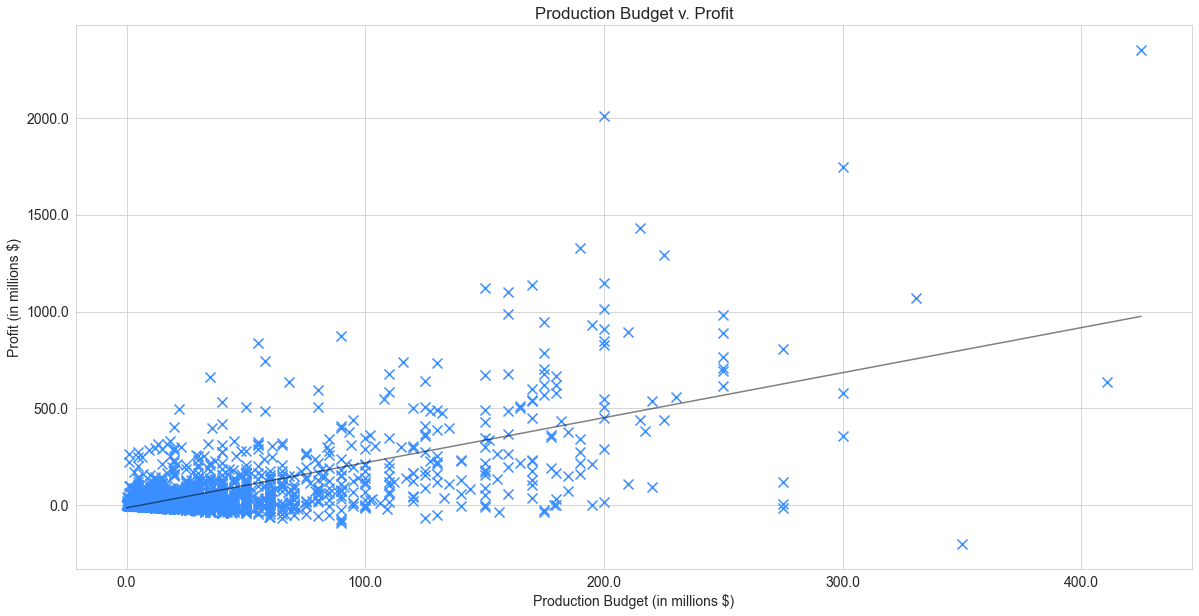

In [129]:
def millions(x, pos):
    return f'{x * 1e-6}'

formatter = mtick.FuncFormatter(millions)

budget_profit_regression_df.plot.scatter(x='production_budget', y='profit', figsize=(20, 10), s=100, marker='x', c="#3A8EFF")

plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().yaxis.set_major_formatter(formatter)

coef = lin_reg.params[1]
intercept = lin_reg.params[0]
x = np.linspace(budget_profit_regression_df['production_budget'].min(), budget_profit_regression_df['production_budget'].max(), 100)
y = coef * x + intercept
plt.plot(x, y, color='k', alpha=.5)

plt.title('Production Budget v. Profit')
plt.xlabel('Production Budget (in millions $)')
plt.ylabel('Profit (in millions $)')
plt.show()

# Conclusion

Based on the analysis, several key factors have been identified that can significantly influence the success of your film project: Budget Impact: The analysis suggests that budget plays a crucial role in the success of a film. Larger budgets are associated with higher expected box office gross. However, it is essential to note that higher budgets also come with increased risk. Therefore, filmmakers should carefully evaluate their financial resources and ensure that the budget aligns with the production's potential return on investment. While a larger budget may open doors to grander productions, it's equally essential to manage and optimize expenses to minimize risk.

Genre Selection: The analysis highlights the significance of choosing the right genre for a successful movie. Genres like animation, action and adventure, science fiction, and fantasy have been shown to be more profitable. Filmmakers should consider audience preferences, market trends, and the potential for the chosen genre to attract viewers and generate box office revenue. However, it's essential to maintain creativity and uniqueness within the chosen genre to stand out from the competition and engage the audience effectively. The director's role is significant in shaping the film's overall quality and appeal. Collaborating with experienced and reputable directors can enhance the project's chances of success. Filmmakers should carefully consider a director's track record, style, and vision to ensure alignment with the project's objectives.

In conclusion, a successful film project requires a well-balanced approach that considers budget allocation, genre selection, and directorial expertise. By carefully managing budgetary constraints, strategically choosing popular genres, and collaborating with talented directors, filmmakers can increase the likelihood of realizing a successful movie with positive box office performance. However, it's crucial to maintain a balance between creative expression and commercial viability to resonate with the target audience and achieve both artistic and financial success.

# Next Steps

A data set of nearly 1500 films was used to derive these valuable insights and recommendations. However, it is important to acknowledge that having access to more data, especially concerning film budgets, could further enhance the accuracy and reliability of our recommendations. Having access to more comprehensive and accurate budget data would enable us to conduct more detailed analyses, resulting in better-informed decisions when it comes to allocating budgets and assessing risks, choosing genres, and directors.

This would significantly strengthen our ability to provide more tailored and effective recommendations to maximize the chances of a film's success. Therefore, in future endeavors, obtaining access to improved data sources would be an asset, enabling us to deliver even more valuable insights and strategies for creating successful films in the dynamic and competitive film industry. Therefore, in future analyses, obtaining access to improved data sources would be an asset, enabling us to deliver even more valuable insights and strategies for creating successful films in the dynamic and competitive film industry.